In [74]:
#import the function from functions folder
from functions.functions import get_DataFrame, get_Normalized_DataFrame

# import the libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [75]:
# read the json file
data = get_DataFrame('matches/matches_england.json')

print(f"{len(data)} Matches") 

380 Matches


### Representation of the data without normalizing

In [76]:
df = pd.DataFrame(data)
df.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364


### Manually flatten the data

In [77]:
allTeams = []
formationPlayers = []
subPlayers = []
allReferees = []

for match in data:                                                              # loop through each match
    matchTeamsData = match['teamsData']                                         # get the teams data for each match

    for team in matchTeamsData:                                                 # loop through each team in the match
        
        teamGameStats = matchTeamsData[team]                                    # get the stats for each team in the match
        teamList = list(teamGameStats.values())                                 # get the values for each teams stats in the match and convert to list
        teamList.insert(0, match['wyId'])                                  # insert the match id at the beginning of the list
        allTeams.append(teamList)

        if teamGameStats['hasFormation'] == True:
            for formationBreak in teamGameStats['formation']:                   # loop through each formation break in the match (bench, lineup, subs)
                eachFormBreak = teamGameStats['formation'][formationBreak]
                if eachFormBreak == 'null':                                     # if the formation break is null, skip it
                    continue
                elif formationBreak == 'substitutions':
                    for eachSub in eachFormBreak:                               # loop through each substitution in the match
                        vals = eachSub.values()
                        valList = list(vals)
                        valList.insert(0, f"{match['wyId']}")                   # insert the match id at the beginning of the list
                        if len(valList) < 5:                                    # if the list is less than 6, insert a null value to fill assists
                            valList.insert(2, np.nan)
                        subPlayers.append(valList)
                    continue
                else:
                    for eachPlayer in eachFormBreak:                            # loop through each player in the formation breaks (bench, lineup)
                        vals = eachPlayer.values()
                        valList = list(vals)
                        valList.insert(0, f"{formationBreak}")                  # insert the formation type at the beginning of the list
                        valList.insert(0, f"{match['wyId']}")                   # insert the match id at the beginning of the list
                        if len(valList) < 8:                                    # if the list is less than 8, insert a null value to fill assists
                            valList.insert(3, np.nan)
                        formationPlayers.append(valList)

    referees = match['referees']                                                # get the referees for each match
    refereeList = []
    refereeList.append(int(match['wyId']))                                      # insert the match id at the beginning of the list
    for referee in referees:                                                    # loop through each referee in the match
        refereeList.append(int(referee['refereeId']))

    if len(refereeList) < 7:                                                    # if the list is less than 7, insert a NaN to fill the list
        refereeList.extend([np.nan] * (7 - len(refereeList)))

    allReferees.append(refereeList)

### Players that were in the lineup and bench

In [78]:
players_df = pd.DataFrame(formationPlayers)
players_df.rename(columns={0: 'matchId', 1: 'formation', 2: 'playerId', 3: 'assists', 4: 'ownGoals', 5: 'redCards', 6: 'goals', 7: 'yellowCards'}, inplace=True)
players_df.replace('null', np.nan, inplace=True)
print(players_df.shape)
players_df[['matchId', 'assists', 'ownGoals', 'redCards', 'goals', 'yellowCards']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in players_df[['matchId', 'assists', 'ownGoals', 'redCards', 'goals', 'yellowCards']].items()}, dtype='Int64')
# players with out any red cards or yellow (min) cards are shown 0, but time 0 makes the calculation wrong, so we replace it with NaN
players_df[['redCards', 'yellowCards']] = players_df[['redCards', 'yellowCards']].replace(0, np.nan)
players_df.describe()



(13668, 8)


,matchId,playerId,assists,ownGoals,redCards,goals,yellowCards
count,13668.0,13668.000000,0.0,13668.0,39.0,6241.0,1180.0
mean,2499908.446005,71222.289069,<NA>,0.222271,61.102564,0.158468,60.113559
std,109.714142,111915.842517,<NA>,0.627224,26.344674,0.414535,24.618287
min,2499719.0,36.000000,<NA>,0.0,10.0,0.0,2.0
25%,2499813.0,8186.000000,<NA>,0.0,38.0,0.0,42.0
50%,2499908.0,11152.000000,<NA>,0.0,68.0,0.0,63.0
75%,2500003.0,70965.000000,<NA>,0.0,85.5,0.0,82.0
max,2500098.0,532949.000000,<NA>,2.0,99.0,4.0,97.0


In [79]:
players_df.sort_values(by='goals', ascending=False).head()

,matchId,formation,playerId,assists,ownGoals,redCards,goals,yellowCards
4135,2499982,lineup,8325,<NA>,0,<NA>,4,<NA>
2768,2500023,lineup,120353,<NA>,0,<NA>,4,<NA>
6807,2499916,lineup,8717,<NA>,2,<NA>,3,<NA>
8636,2499856,lineup,7944,<NA>,0,<NA>,3,<NA>
9474,2499829,lineup,11669,<NA>,0,<NA>,3,<NA>


### Substitution details

In [80]:
subs_df = pd.DataFrame(subPlayers)
subs_df.rename(columns={0: 'matchId', 1: 'playerIn', 2: 'assists', 3: 'playerOut', 4: 'minute'}, inplace=True)
subs_df.replace('null', np.nan, inplace=True)
subs_df[['matchId', 'assists', 'minute']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in subs_df[['matchId', 'assists', 'minute']].items()}, dtype='Int64')
print(subs_df.shape)
subs_df.head()


(2083, 5)


,matchId,playerIn,assists,playerOut,minute
0,2500089,9127,<NA>,9206,61
1,2500089,9179,<NA>,93,80
2,2500089,532949,<NA>,8284,94
3,2500089,7989,<NA>,259531,59
4,2500089,11669,<NA>,245813,59


In [81]:
subs_df.describe()

,matchId,playerIn,assists,playerOut,minute
count,2083.0,2083.000000,0.0,2083.000000,2083.0
mean,2499908.023524,95287.219395,<NA>,63549.023524,71.154585
std,110.70173,128702.674150,<NA>,102439.832384,14.546131
min,2499719.0,36.000000,<NA>,38.000000,3.0
25%,2499811.0,8384.000000,<NA>,8284.000000,64.0
50%,2499906.0,20505.000000,<NA>,12536.000000,74.0
75%,2500005.0,145692.000000,<NA>,70085.500000,82.0
max,2500098.0,532949.000000,<NA>,486252.000000,95.0


### Team details

In [82]:
team_df = pd.DataFrame(allTeams)
team_df.drop([8], axis=1, inplace=True)
team_df.rename(columns={0: 'matchId', 1: 'scoreET', 2: 'coachId', 3: 'side', 4: 'teamId', 5: 'score', 6: 'scoreP', 7: 'hasFormation', 9: 'scoreHT'}, inplace=True)
# Coach Id can not be 0, so we replace it with NaN
team_df['coachId'] = team_df['coachId'].replace(0, np.nan)
team_df.head()

,matchId,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT
0,2500089,0,8880.0,home,1646,1,0,1,1
1,2500089,0,8934.0,away,1659,2,0,1,0
2,2500090,0,8357.0,home,1628,2,0,1,0
3,2500090,0,NaN,away,1627,0,0,1,0
4,2500091,0,7845.0,away,1609,1,0,1,1


In [83]:
team_df.describe()

,matchId,scoreET,coachId,teamId,score,scoreP,hasFormation,scoreHT
count,7.600000e+02,760.0,715.000000,760.000000,760.000000,760.0,760.0,760.000000
mean,2.499908e+06,0.0,104966.591608,2075.400000,1.339474,0.0,1.0,0.560526
std,1.097684e+02,0.0,125302.764295,1941.199054,1.275293,0.0,0.0,0.776139
min,2.499719e+06,0.0,3295.000000,1609.000000,0.000000,0.0,1.0,0.000000
25%,2.499814e+06,0.0,8357.000000,1617.500000,0.000000,0.0,1.0,0.000000
50%,2.499908e+06,0.0,14791.000000,1627.500000,1.000000,0.0,1.0,0.000000
75%,2.500003e+06,0.0,254174.000000,1644.500000,2.000000,0.0,1.0,1.000000
max,2.500098e+06,0.0,531745.000000,10531.000000,7.000000,0.0,1.0,4.000000


### Matches

In [84]:
matches_df = pd.DataFrame(data)
matches_df.drop(['teamsData'], axis=1, inplace=True)
matches_df.drop(['referees'], axis=1, inplace=True)
matches_df.rename(columns={'wyId': 'matchId'}, inplace=True)
# winning team id can not be 0, so we replace it with NaN (draw)
matches_df['winner'] = matches_df['winner'].replace(0, np.nan)
matches_df.describe()

,roundId,gameweek,seasonId,winner,matchId,competitionId
count,380.0,380.000000,380.0,279.000000,3.800000e+02,380.0
mean,4405654.0,19.500000,181150.0,1881.602151,2.499908e+06,364.0
std,0.0,10.980313,0.0,1488.850654,1.098408e+02,0.0
min,4405654.0,1.000000,181150.0,1609.000000,2.499719e+06,364.0
25%,4405654.0,10.000000,181150.0,1612.000000,2.499814e+06,364.0
50%,4405654.0,19.500000,181150.0,1624.000000,2.499908e+06,364.0
75%,4405654.0,29.000000,181150.0,1633.000000,2.500003e+06,364.0
max,4405654.0,38.000000,181150.0,10531.000000,2.500098e+06,364.0


In [85]:
matches_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,date,duration,competitionId
0,Played,4405654,38,181150,2018-05-13 14:00:00,1659.0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364
1,Played,4405654,38,181150,2018-05-13 14:00:00,1628.0,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364
2,Played,4405654,38,181150,2018-05-13 14:00:00,1609.0,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364
3,Played,4405654,38,181150,2018-05-13 14:00:00,1612.0,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364
4,Played,4405654,38,181150,2018-05-13 14:00:00,1611.0,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364


### Referees

In [86]:
referees_df = pd.DataFrame(allReferees)
referees_df.rename(columns={0: 'matchId', 1: 'referee', 2: 'firstAssistant', 3: 'secondAssistant', 4: 'fourthOfficial', 5: 'firstAdditionalAssistant', 6: 'secondAdditionalAssistant'}, inplace=True)
referees_df.head()

,matchId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant
0,2500089,385705.0,385733.0,385922.0,388333.0,NaN,NaN
1,2500090,381851.0,385011.0,385920.0,381852.0,NaN,NaN
2,2500091,384965.0,381917.0,383201.0,385737.0,NaN,NaN
3,2500092,385704.0,385919.0,456216.0,NaN,NaN,NaN
4,2500093,381853.0,386732.0,393151.0,385915.0,NaN,NaN


In [87]:
referees_df.describe()

,matchId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant
count,3.800000e+02,378.000000,378.000000,378.000000,377.000000,0.0,0.0
mean,2.499908e+06,385166.134921,384511.277778,389574.888889,385578.299735,NaN,NaN
std,1.098408e+02,6088.097808,1875.845494,16402.158745,6004.503475,NaN,NaN
min,2.499719e+06,378951.000000,379551.000000,379551.000000,378951.000000,NaN,NaN
25%,2.499814e+06,381851.250000,383201.000000,385011.000000,381853.000000,NaN,NaN
50%,2.499908e+06,385704.000000,385005.000000,385918.000000,385737.000000,NaN,NaN
75%,2.500003e+06,385911.000000,385917.000000,386445.250000,385915.000000,NaN,NaN
max,2.500098e+06,408156.000000,386732.000000,456216.000000,408156.000000,NaN,NaN


## Merging matches with teams

In [88]:
match_team_df = matches_df.merge(team_df, on='matchId', how='left')
# If winning team, replaces winner column with 1, else 0
match_team_df['winner'] = np.where(match_team_df['teamId'] == match_team_df['winner'], 1, 0)
match_team_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,date,duration,competitionId,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT
0,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,0,8880.0,home,1646,1,0,1,1
1,Played,4405654,38,181150,2018-05-13 14:00:00,1,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,0,8934.0,away,1659,2,0,1,0
2,Played,4405654,38,181150,2018-05-13 14:00:00,1,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,0,8357.0,home,1628,2,0,1,0
3,Played,4405654,38,181150,2018-05-13 14:00:00,0,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,0,NaN,away,1627,0,0,1,0
4,Played,4405654,38,181150,2018-05-13 14:00:00,1,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2",Regular,364,0,7845.0,away,1609,1,0,1,1


In [89]:
teams_df_norm = get_Normalized_DataFrame('data/teams.json')
teams_df_norm.rename(columns={'wyId': 'teamId'}, inplace=True)
teams_df_norm[['area.id']] = teams_df_norm[['area.id']].astype('int64')
teams_df_norm[['area.id']] = teams_df_norm[['area.id']].replace(0, np.nan)
# fill empty values with NaN
teams_df_norm.replace('', np.nan, inplace=True)
teams_df_norm.head()

,city,name,teamId,officialName,type,area.name,area.id,area.alpha3code,area.alpha2code
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,club,England,NaN,XEN,NaN
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,club,Spain,724.0,ESP,ES
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,club,Spain,724.0,ESP,ES
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,club,Spain,724.0,ESP,ES
4,Valencia,Levante,695,Levante UD,club,Spain,724.0,ESP,ES


In [90]:
match_team_ext_df = match_team_df.merge(teams_df_norm, on='teamId', how='left')
match_team_ext_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,date,...,hasFormation,scoreHT,city,name,officialName,type,area.name,area.id,area.alpha3code,area.alpha2code
0,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",...,1,1,"Burnley, Lancashire",Burnley,Burnley FC,club,England,NaN,XEN,NaN
1,Played,4405654,38,181150,2018-05-13 14:00:00,1,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2",...,1,0,"Bournemouth, Dorset",AFC Bournemouth,AFC Bournemouth,club,England,NaN,XEN,NaN
2,Played,4405654,38,181150,2018-05-13 14:00:00,1,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2",...,1,0,London,Crystal Palace,Crystal Palace FC,club,England,NaN,XEN,NaN
3,Played,4405654,38,181150,2018-05-13 14:00:00,0,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2",...,1,0,West Bromwich,West Bromwich Albion,West Bromwich Albion FC,club,England,NaN,XEN,NaN
4,Played,4405654,38,181150,2018-05-13 14:00:00,1,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2",...,1,1,London,Arsenal,Arsenal FC,club,England,NaN,XEN,NaN


In [91]:
match_team_ext_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId', 'label', 'date', 'duration', 'competitionId',
       'scoreET', 'coachId', 'side', 'teamId', 'score', 'scoreP',
       'hasFormation', 'scoreHT', 'city', 'name', 'officialName', 'type',
       'area.name', 'area.id', 'area.alpha3code', 'area.alpha2code'],
      dtype='object')

In [92]:
match_team_ext_df.drop(['hasFormation', 'area.name', 'area.alpha3code', 'area.alpha2code','name', 'city', 'type', 'date'], axis=1, inplace=True)
match_team_ext_df[['coachId', 'area.id']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in match_team_ext_df[['coachId', 'area.id']].items()}, dtype='Int64')
match_team_ext_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,duration,competitionId,scoreET,coachId,side,teamId,score,scoreP,scoreHT,officialName,area.id
0,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,364,0,8880,home,1646,1,0,1,Burnley FC,<NA>
1,Played,4405654,38,181150,2018-05-13 14:00:00,1,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,364,0,8934,away,1659,2,0,0,AFC Bournemouth,<NA>
2,Played,4405654,38,181150,2018-05-13 14:00:00,1,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",Regular,364,0,8357,home,1628,2,0,0,Crystal Palace FC,<NA>
3,Played,4405654,38,181150,2018-05-13 14:00:00,0,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",Regular,364,0,<NA>,away,1627,0,0,0,West Bromwich Albion FC,<NA>
4,Played,4405654,38,181150,2018-05-13 14:00:00,1,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1",Regular,364,0,7845,away,1609,1,0,1,Arsenal FC,<NA>


### Merge with Players in match

In [93]:
match_team_ply_df = match_team_ext_df.merge(players_df, on='matchId', how='left')
match_team_ply_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,duration,...,scoreHT,officialName,area.id,formation,playerId,assists,ownGoals,redCards,goals,yellowCards
0,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,1,Burnley FC,<NA>,bench,77502,<NA>,0,<NA>,<NA>,<NA>
1,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,1,Burnley FC,<NA>,bench,270828,<NA>,0,<NA>,<NA>,<NA>
2,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,1,Burnley FC,<NA>,bench,9164,<NA>,0,<NA>,<NA>,<NA>
3,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,1,Burnley FC,<NA>,bench,8516,<NA>,0,<NA>,<NA>,<NA>
4,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,1,Burnley FC,<NA>,bench,9179,<NA>,0,<NA>,<NA>,<NA>


In [94]:
match_team_ply_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId', 'label', 'duration', 'competitionId', 'scoreET',
       'coachId', 'side', 'teamId', 'score', 'scoreP', 'scoreHT',
       'officialName', 'area.id', 'formation', 'playerId', 'assists',
       'ownGoals', 'redCards', 'goals', 'yellowCards'],
      dtype='object')

### Merge with substitution players

In [95]:
subs_df.rename(columns={'playerIn': 'playerId'}, inplace=True)
match_team_ply_s_df = match_team_ply_df.merge(subs_df[['matchId', 'playerId', 'minute']], on='playerId', how='left')
match_team_ply_s_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId_x,label,duration,...,area.id,formation,playerId,assists,ownGoals,redCards,goals,yellowCards,matchId_y,minute
0,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,<NA>,bench,77502,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>
1,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,<NA>,bench,270828,<NA>,0,<NA>,<NA>,<NA>,2500080,71
2,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,<NA>,bench,270828,<NA>,0,<NA>,<NA>,<NA>,2500069,72
3,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,<NA>,bench,270828,<NA>,0,<NA>,<NA>,<NA>,2499986,85
4,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,<NA>,bench,270828,<NA>,0,<NA>,<NA>,<NA>,2499964,82


In [96]:
match_team_ply_s_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId_x', 'label', 'duration', 'competitionId', 'scoreET',
       'coachId', 'side', 'teamId', 'score', 'scoreP', 'scoreHT',
       'officialName', 'area.id', 'formation', 'playerId', 'assists',
       'ownGoals', 'redCards', 'goals', 'yellowCards', 'matchId_y', 'minute'],
      dtype='object')

### Merge with Player info in data

In [97]:
player_df_norm = get_Normalized_DataFrame('data/players.json')
print(player_df_norm.shape)
player_df_norm.columns

(3603, 22)


Index(['weight', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'height', 'wyId', 'foot', 'shortName',
       'currentNationalTeamId', 'passportArea.name', 'passportArea.id',
       'passportArea.alpha3code', 'passportArea.alpha2code', 'role.code2',
       'role.code3', 'role.name', 'birthArea.name', 'birthArea.id',
       'birthArea.alpha3code', 'birthArea.alpha2code'],
      dtype='object')

In [98]:
player_df_norm.drop(['middleName', 'shortName', 'passportArea.alpha3code', 'passportArea.alpha2code', 'passportArea.name', 'passportArea.id', 'birthArea.alpha3code', 'birthArea.alpha2code', 'birthArea.id', 'role.code2', 'role.code3'], axis=1, inplace=True)
player_df_norm.rename(columns={'wyId': 'playerId', 'role.name': 'role'}, inplace=True)

In [99]:
player_df_norm = player_df_norm[['playerId', 'firstName', 'lastName', 'currentTeamId', 'role', 'birthDate', 'weight', 'height', 'foot', 'currentNationalTeamId', 'birthArea.name']]
player_df_norm[['currentTeamId', 'currentNationalTeamId']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in player_df_norm[['currentTeamId', 'currentNationalTeamId']].items()}, dtype='Int64')
player_df_norm = player_df_norm.replace(0, np.nan)
player_df_norm.rename(columns={'currentTeamId': 'teamId'}, inplace=True)
player_df_norm['foot'] = player_df_norm['foot'].replace('', np.nan)
player_df_norm.describe()

,playerId,teamId,weight,height,currentNationalTeamId
count,3603.000000,3468.0,3510.00000,3526.000000,1357.0
mean,142407.543991,4634.977797,76.32792,182.391946,10435.886514
std,153687.689153,6289.428109,6.96483,6.583675,5732.018077
min,12.000000,8.0,55.00000,162.000000,664.0
25%,15981.000000,1628.0,72.00000,178.000000,5629.0
50%,70096.000000,3162.0,76.00000,183.000000,10451.0
75%,264883.500000,3787.0,81.00000,187.000000,15594.0
max,568583.000000,63189.0,101.00000,203.000000,34101.0


In [100]:
player_df_norm.head()

,playerId,firstName,lastName,teamId,role,birthDate,weight,height,foot,currentNationalTeamId,birthArea.name
0,32777,Harun,Tekin,4502,Goalkeeper,1989-06-17,78.0,187.0,right,4687,Turkey
1,393228,Malang,Sarr,3775,Defender,1999-01-23,73.0,182.0,left,4423,France
2,393230,Over,Mandanda,3772,Goalkeeper,1998-10-26,72.0,176.0,NaN,<NA>,France
3,32793,Alfred John Momar,N'Diaye,683,Midfielder,1990-03-06,82.0,187.0,right,19314,France
4,393247,Ibrahima,Konat\u00e9,2975,Defender,1999-05-25,84.0,192.0,right,<NA>,France


In [101]:
match_team_ply_s_dply_df = match_team_ply_s_df.merge(player_df_norm, on='playerId', how='left')
# match_team_ply_s_dply_df['teamId_x']
match_team_ply_s_dply_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId_x,label,duration,...,firstName,lastName,teamId_y,role,birthDate,weight,height,foot,currentNationalTeamId,birthArea.name
0,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,Tom,Heaton,1646,Goalkeeper,1986-04-15,86.0,188.0,right,<NA>,England
1,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,Georges-Kevin,N'Koudou Mbida,1624,Forward,1995-02-13,73.0,175.0,right,<NA>,France
2,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,Georges-Kevin,N'Koudou Mbida,1624,Forward,1995-02-13,73.0,175.0,right,<NA>,France
3,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,Georges-Kevin,N'Koudou Mbida,1624,Forward,1995-02-13,73.0,175.0,right,<NA>,France
4,Played,4405654,38,181150,2018-05-13 14:00:00,0,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",Regular,...,Georges-Kevin,N'Koudou Mbida,1624,Forward,1995-02-13,73.0,175.0,right,<NA>,France


In [102]:
match_team_ply_s_dply_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId_x', 'label', 'duration', 'competitionId', 'scoreET',
       'coachId', 'side', 'teamId_x', 'score', 'scoreP', 'scoreHT',
       'officialName', 'area.id', 'formation', 'playerId', 'assists',
       'ownGoals', 'redCards', 'goals', 'yellowCards', 'matchId_y', 'minute',
       'firstName', 'lastName', 'teamId_y', 'role', 'birthDate', 'weight',
       'height', 'foot', 'currentNationalTeamId', 'birthArea.name'],
      dtype='object')

In [103]:
match_team_ply_s_dply_df.drop(['area.id', 'assists'], axis=1, inplace=True)
match_team_ply_s_dply_df.dtypes

status                    object
roundId                    int64
gameweek                   int64
seasonId                   int64
dateutc                   object
winner                     int64
venue                     object
matchId_x                  int64
label                     object
duration                  object
competitionId              int64
scoreET                    int64
coachId                    Int64
side                      object
teamId_x                   int64
score                      int64
scoreP                     int64
scoreHT                    int64
officialName              object
formation                 object
playerId                   int64
ownGoals                   Int64
redCards                   Int64
goals                      Int64
yellowCards                Int64
matchId_y                  Int64
minute                     Int64
firstName                 object
lastName                  object
teamId_y                   Int64
role      

In [104]:
match_team_ply_s_dply_df.describe().T

,count,mean,std,min,25%,50%,75%,max
roundId,125252.0,4405654.0,0.0,4405654.0,4405654.0,4405654.0,4405654.0,4405654.0
gameweek,125252.0,19.404656,10.884041,1.0,10.0,19.0,29.0,38.0
seasonId,125252.0,181150.0,0.0,181150.0,181150.0,181150.0,181150.0,181150.0
winner,125252.0,0.368122,0.482297,0.0,0.0,0.0,1.0,1.0
matchId_x,125252.0,2499907.772028,108.84571,2499719.0,2499814.0,2499906.0,2500003.0,2500098.0
competitionId,125252.0,364.0,0.0,364.0,364.0,364.0,364.0,364.0
scoreET,125252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
coachId,117668.0,107578.659746,125899.267016,3295.0,8357.0,18572.0,254174.0,531745.0
teamId_x,125252.0,2089.427881,1968.951168,1609.0,1613.0,1627.0,1646.0,10531.0
score,125252.0,1.336066,1.275075,0.0,0.0,1.0,2.0,7.0


### Convert to bool 

In [105]:
match_team_ply_s_dply_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId_x', 'label', 'duration', 'competitionId', 'scoreET',
       'coachId', 'side', 'teamId_x', 'score', 'scoreP', 'scoreHT',
       'officialName', 'formation', 'playerId', 'ownGoals', 'redCards',
       'goals', 'yellowCards', 'matchId_y', 'minute', 'firstName', 'lastName',
       'teamId_y', 'role', 'birthDate', 'weight', 'height', 'foot',
       'currentNationalTeamId', 'birthArea.name'],
      dtype='object')

In [106]:
m_t_p_dp_changed = match_team_ply_s_dply_df.drop(['status', 'roundId', 'seasonId', 'dateutc', 'venue', 'matchId_x', 'matchId_y', 'label', 'competitionId', 'coachId', 'teamId_x', 'officialName', 'playerId', 'firstName', 'lastName', 'teamId_y', 'role', 'birthDate', 'currentNationalTeamId', 'birthArea.name'], axis=1)
print(m_t_p_dp_changed.columns)

# Regular is 0, ExtraTime is 1, Penalties is 2
m_t_p_dp_changed['duration'] = m_t_p_dp_changed['duration'].replace('Regular', 0)
m_t_p_dp_changed['duration'] = m_t_p_dp_changed['duration'].replace('ExtraTime', 1)
m_t_p_dp_changed['duration'] = m_t_p_dp_changed['duration'].replace('Penalties', 2)

# Home is 0, Away is 1
m_t_p_dp_changed['side'] = m_t_p_dp_changed['side'].replace('home', 0)
m_t_p_dp_changed['side'] = m_t_p_dp_changed['side'].replace('away', 1)

# bench is 0, lineup is 1
m_t_p_dp_changed['formation'] = m_t_p_dp_changed['formation'].replace('bench', 0)
m_t_p_dp_changed['formation'] = m_t_p_dp_changed['formation'].replace('lineup', 1)

# left is 0, right is 1, both is 2
m_t_p_dp_changed['foot'] = m_t_p_dp_changed['foot'].replace('left', 0)
m_t_p_dp_changed['foot'] = m_t_p_dp_changed['foot'].replace('right', 1)
m_t_p_dp_changed['foot'] = m_t_p_dp_changed['foot'].replace('both', 2)

m_t_p_dp_changed.head()

Index(['gameweek', 'winner', 'duration', 'scoreET', 'side', 'score', 'scoreP',
       'scoreHT', 'formation', 'ownGoals', 'redCards', 'goals', 'yellowCards',
       'minute', 'weight', 'height', 'foot'],
      dtype='object')


,gameweek,winner,duration,scoreET,side,score,scoreP,scoreHT,formation,ownGoals,redCards,goals,yellowCards,minute,weight,height,foot
0,38,0,0,0,0,1,0,1,0,0,<NA>,<NA>,<NA>,<NA>,86.0,188.0,1.0
1,38,0,0,0,0,1,0,1,0,0,<NA>,<NA>,<NA>,71,73.0,175.0,1.0
2,38,0,0,0,0,1,0,1,0,0,<NA>,<NA>,<NA>,72,73.0,175.0,1.0
3,38,0,0,0,0,1,0,1,0,0,<NA>,<NA>,<NA>,85,73.0,175.0,1.0
4,38,0,0,0,0,1,0,1,0,0,<NA>,<NA>,<NA>,82,73.0,175.0,1.0


# Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


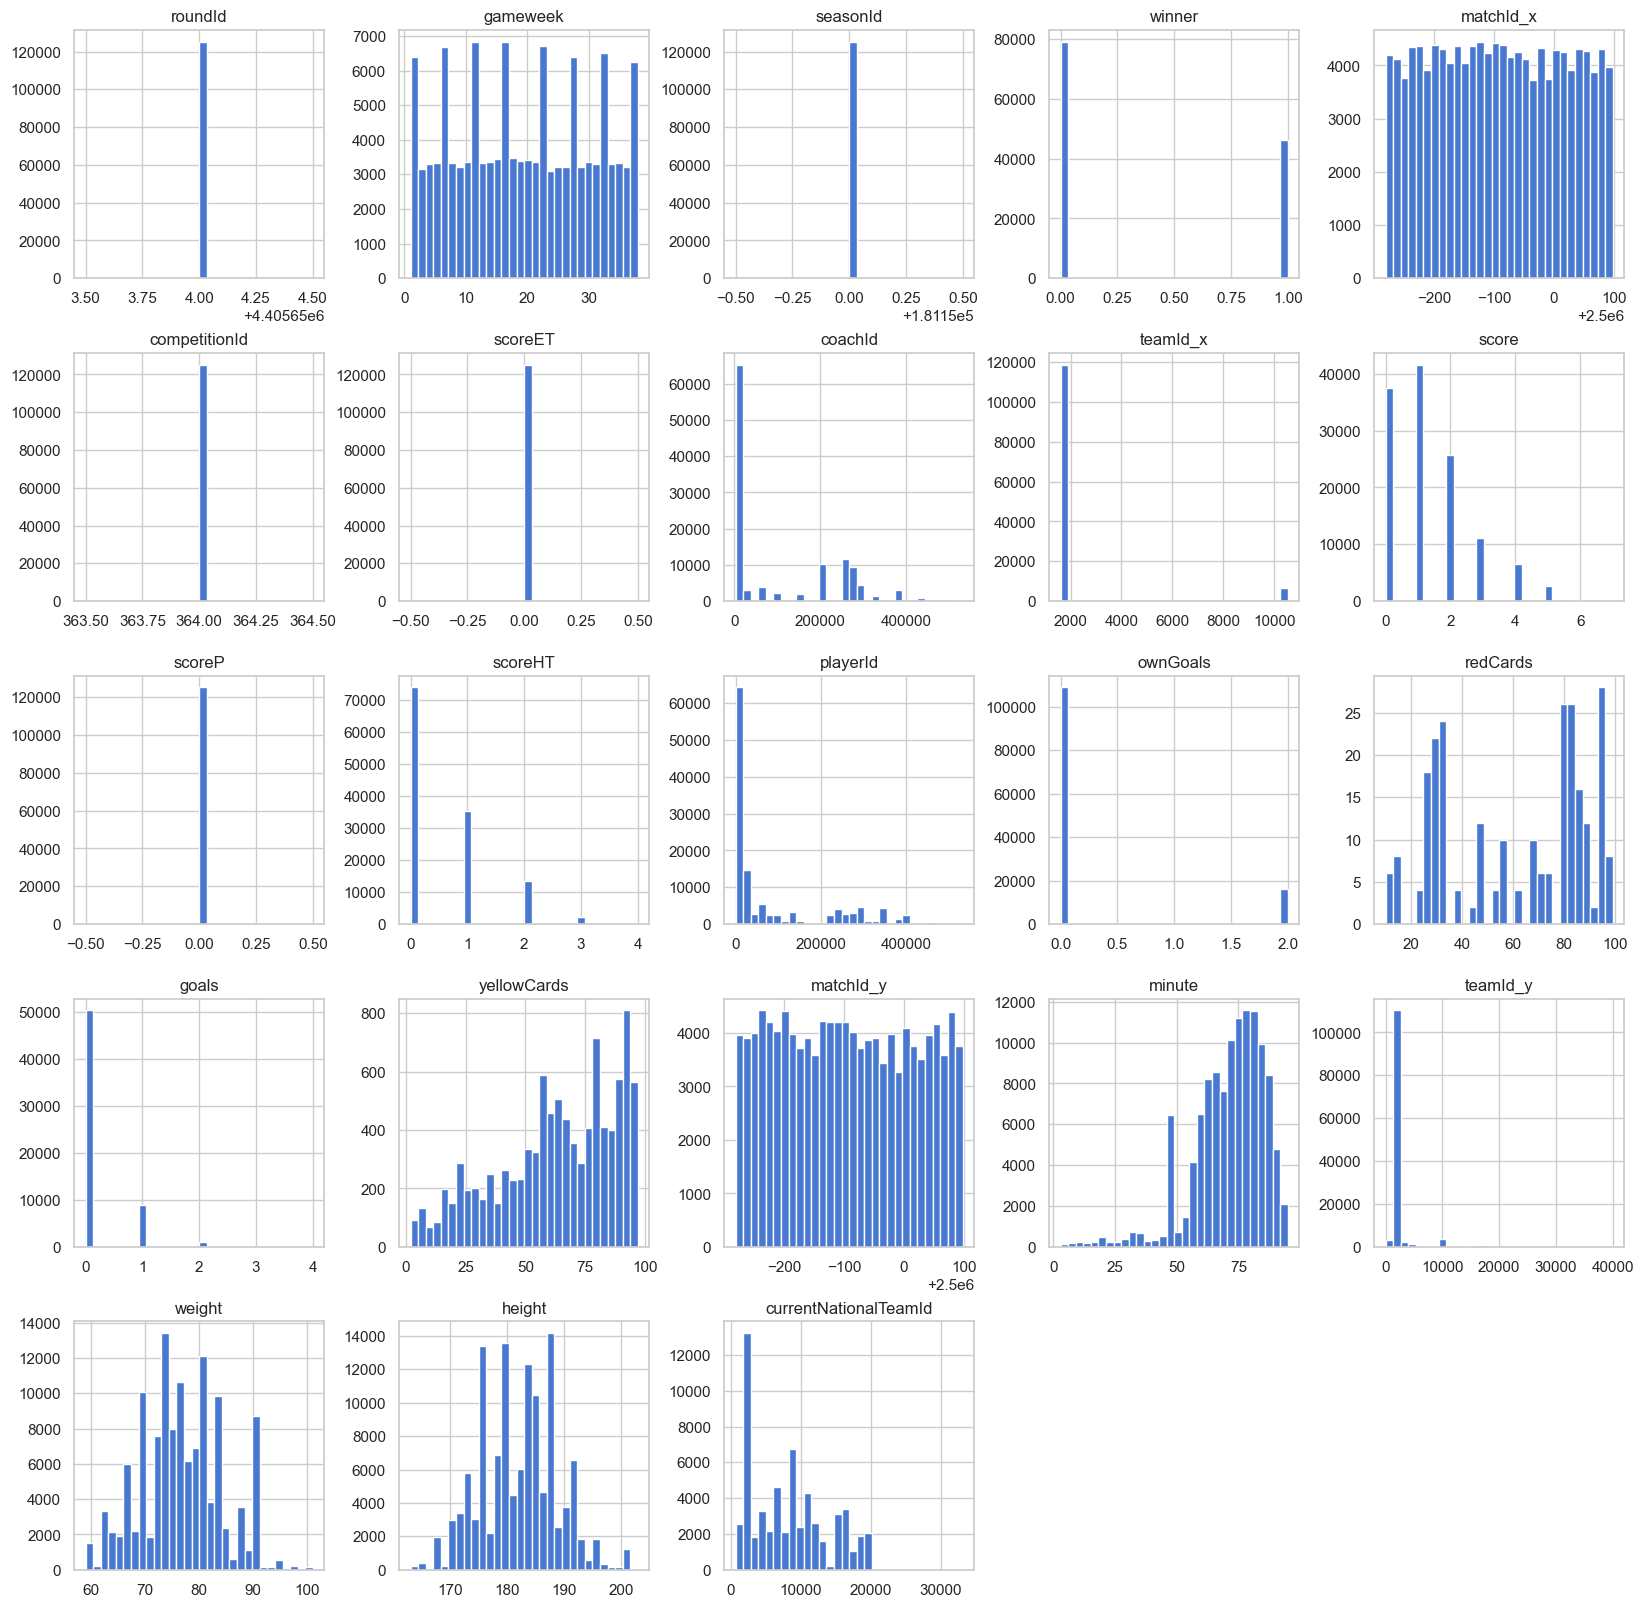

In [126]:
match_team_ply_s_dply_df.hist(figsize=(20, 20), bins=30)
plt.show()

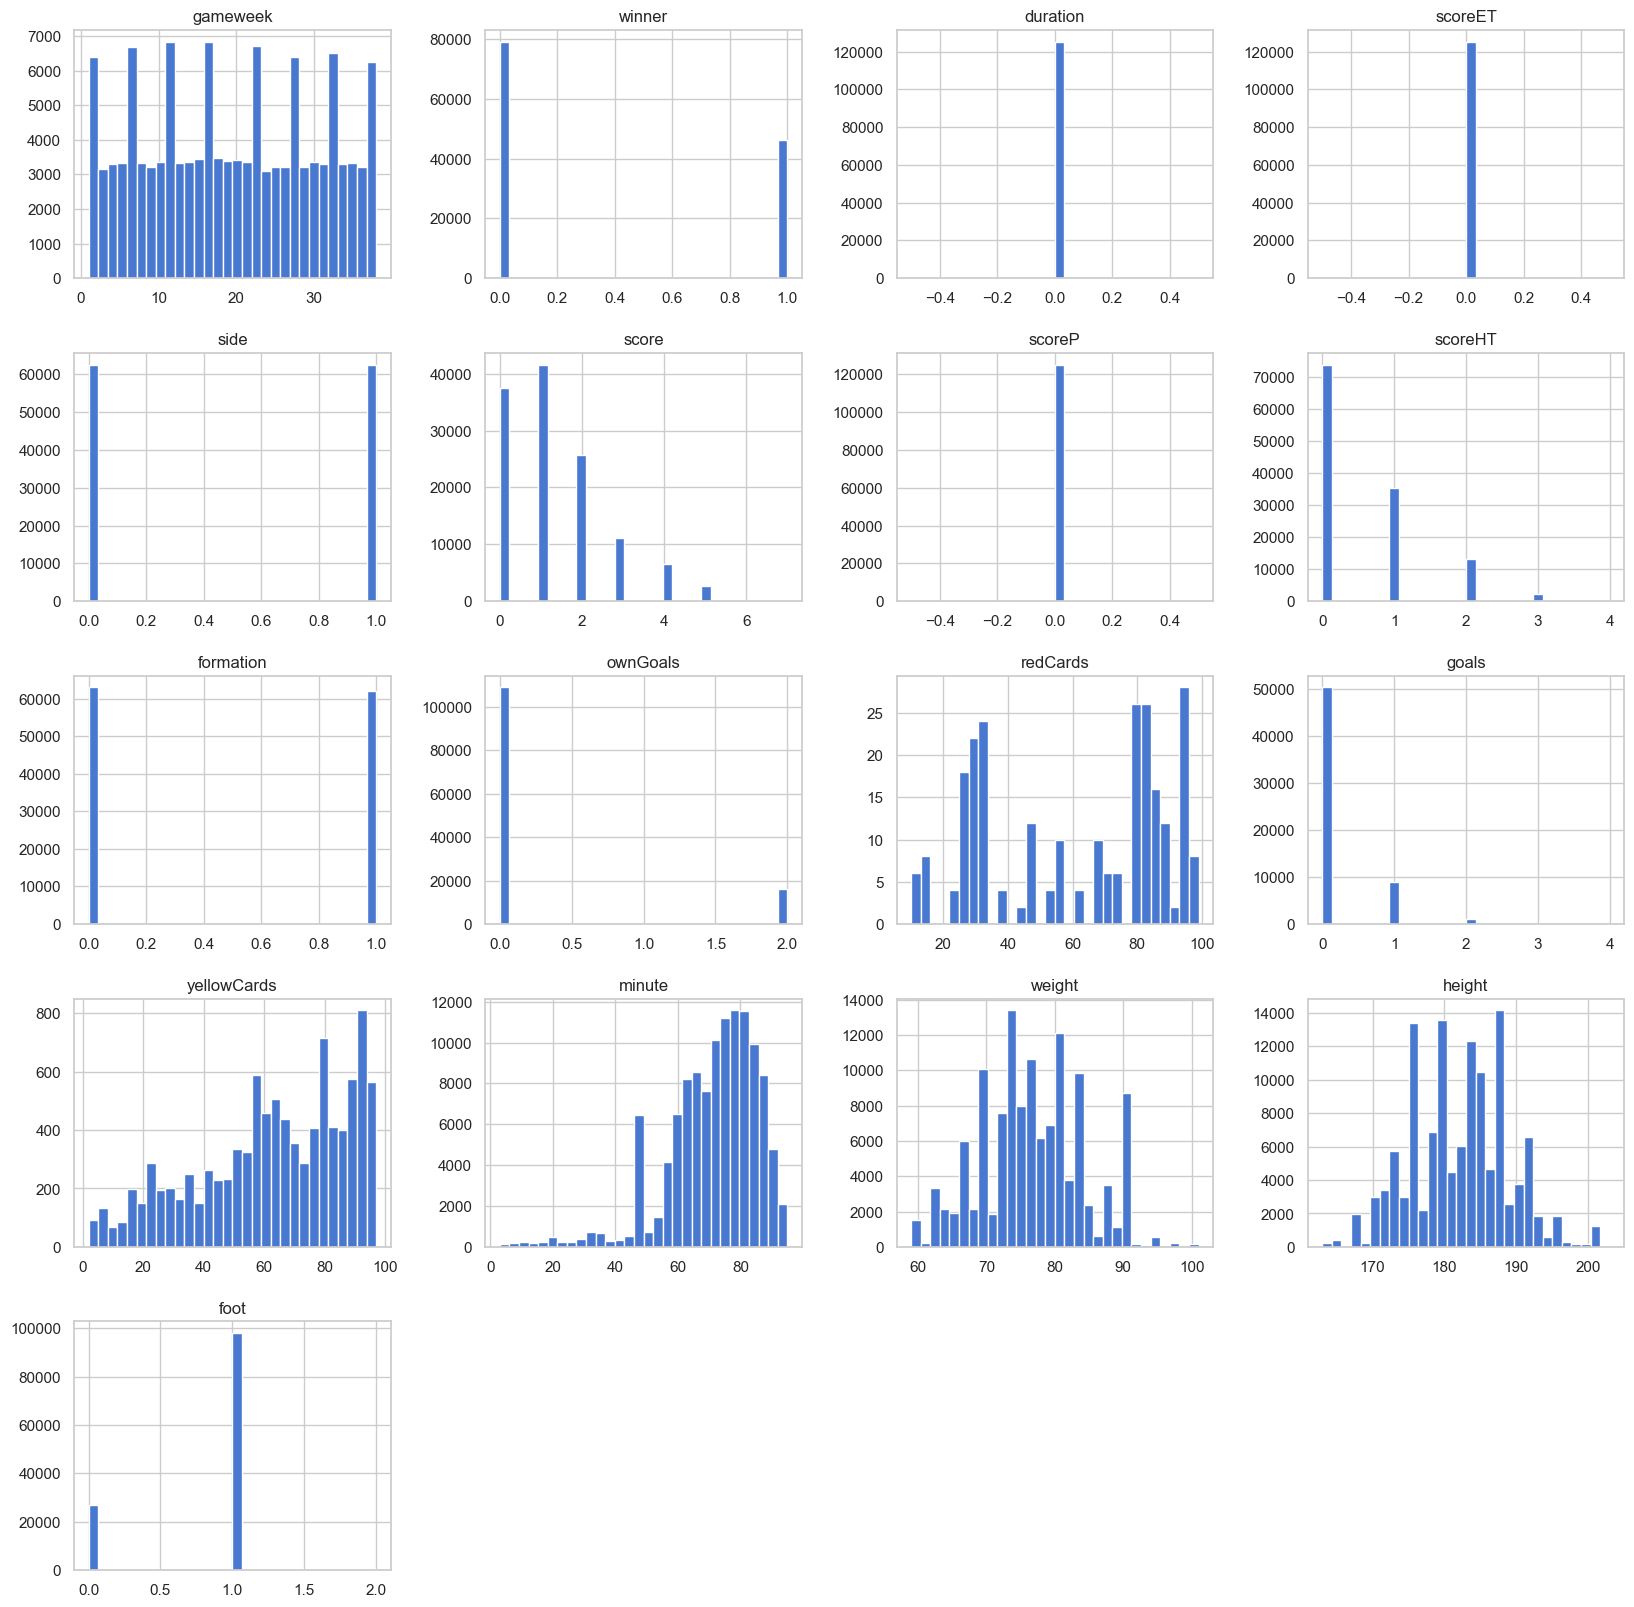

In [108]:
# lable the plt properly
m_t_p_dp_changed.hist(figsize=(20, 20), bins=30)
plt.show()

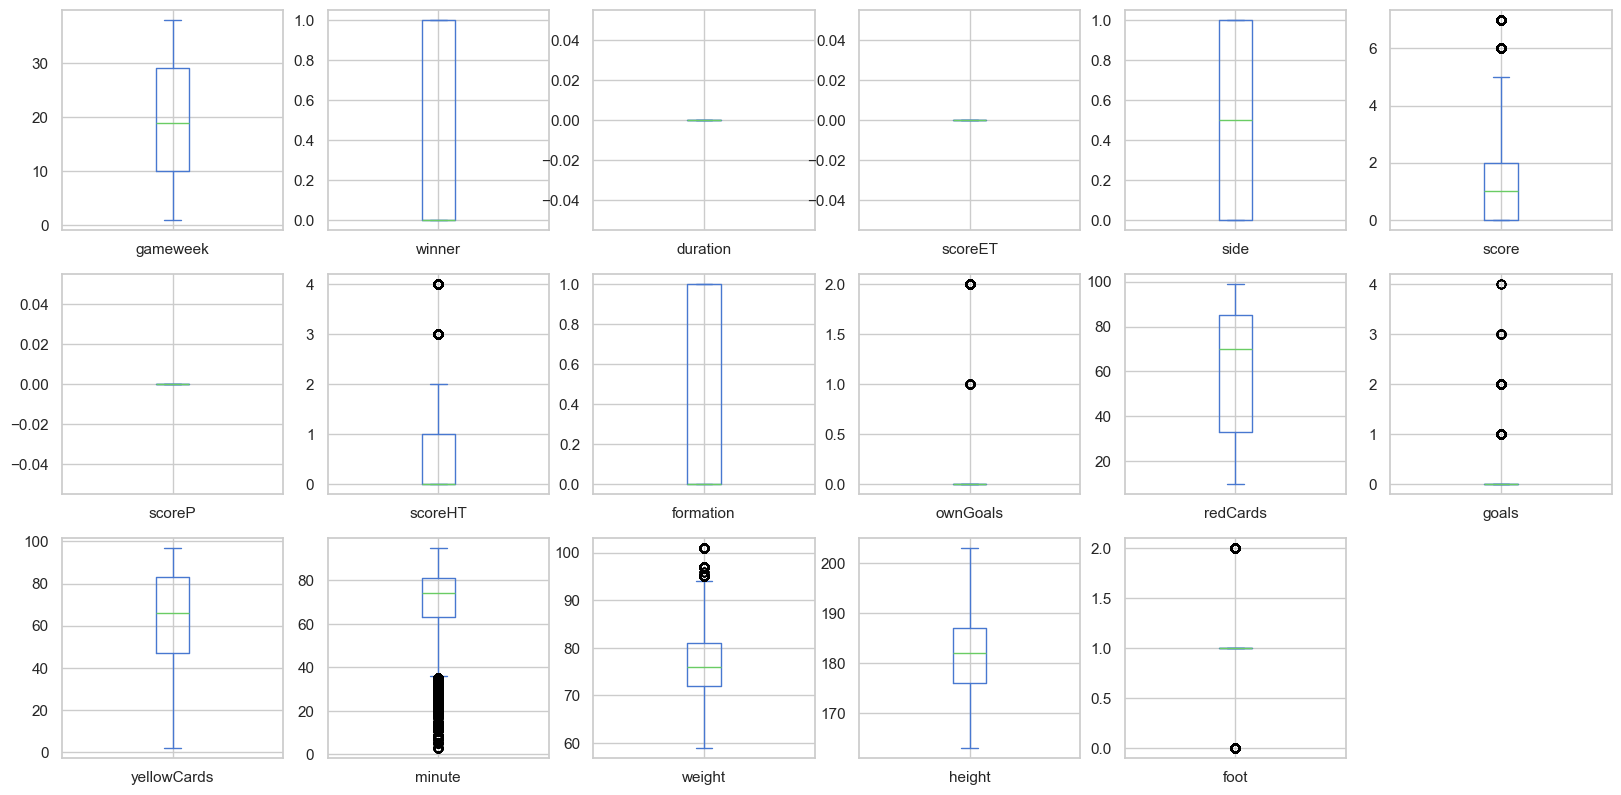

In [109]:
m_t_p_dp_changed.plot(kind='box', subplots=True, layout=(6,6), sharex=False, sharey=False, figsize=(20, 20))
plt.show()

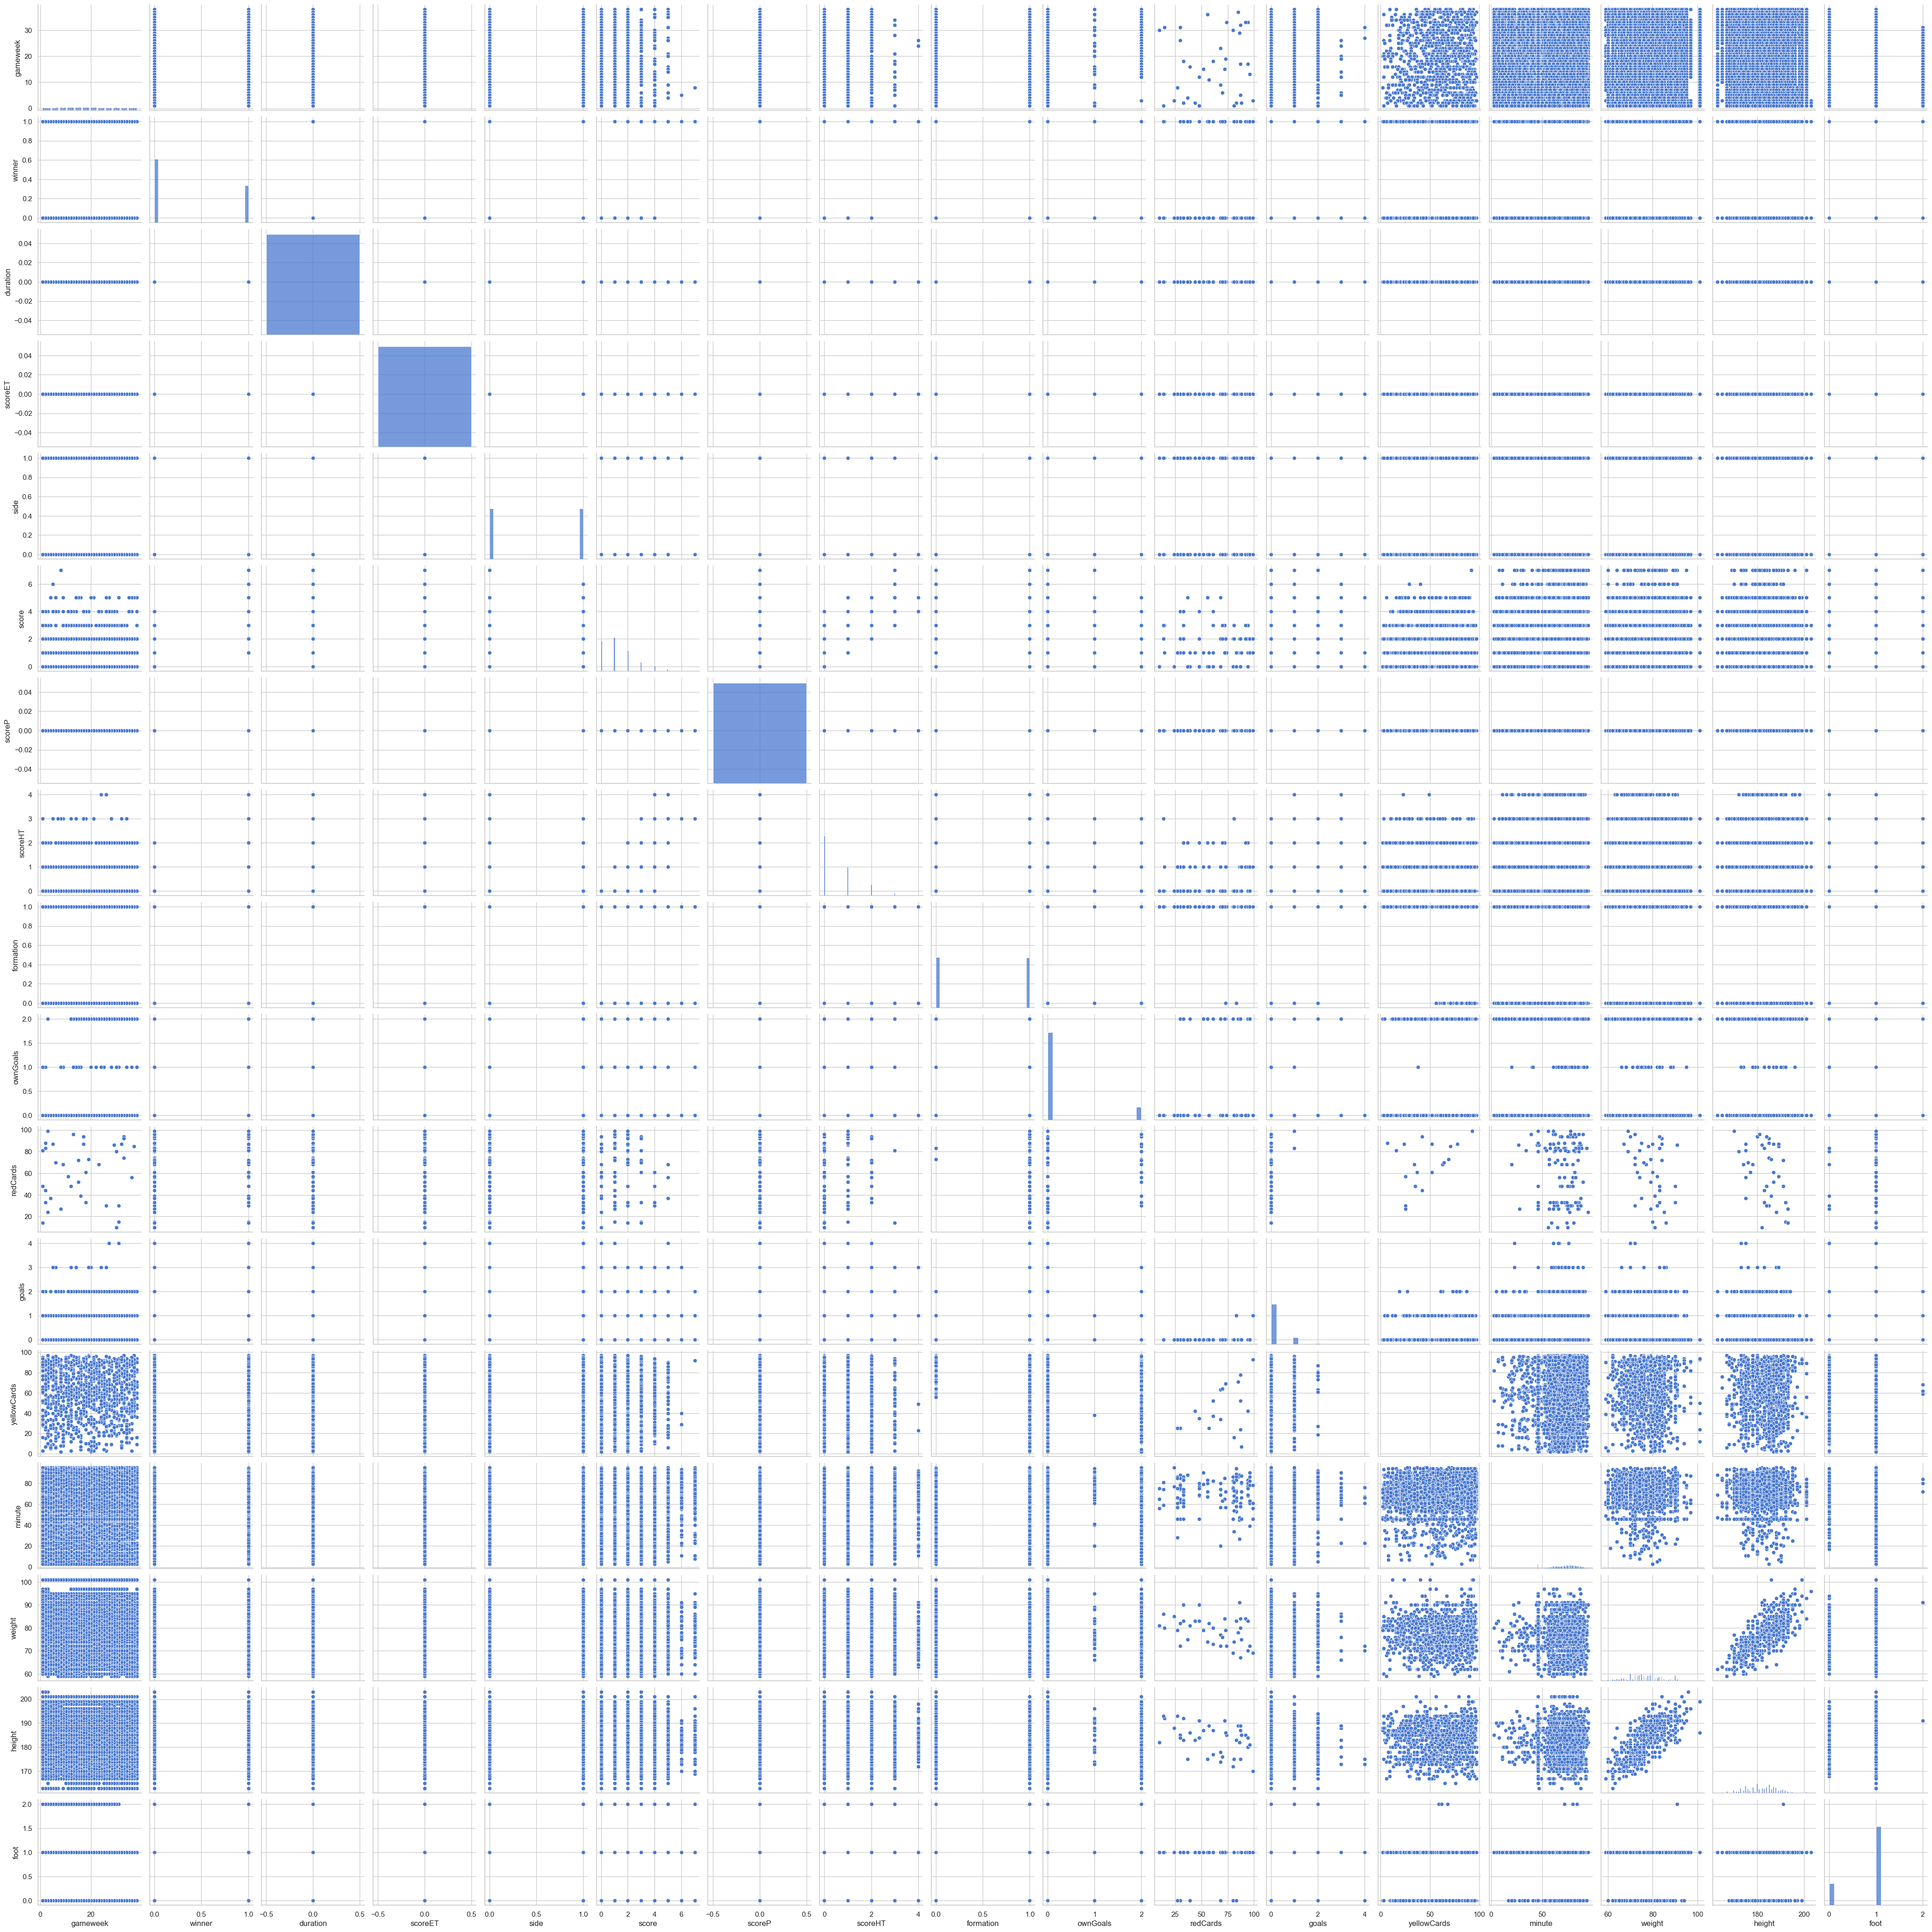

In [110]:
sns.pairplot(m_t_p_dp_changed, height=2.5)
plt.show()

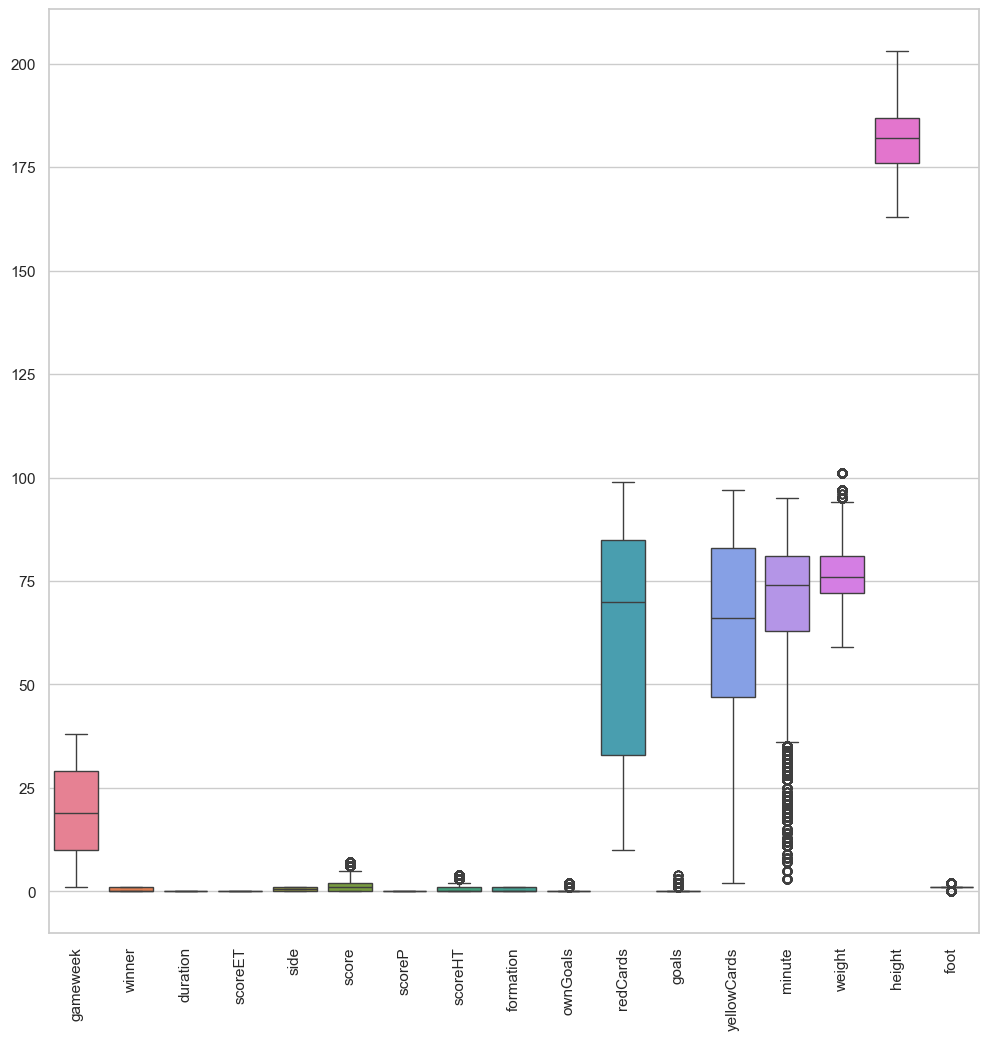

In [111]:
sns.set(style='whitegrid', palette='muted')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=m_t_p_dp_changed)
plt.xticks(rotation=90)
plt.show()

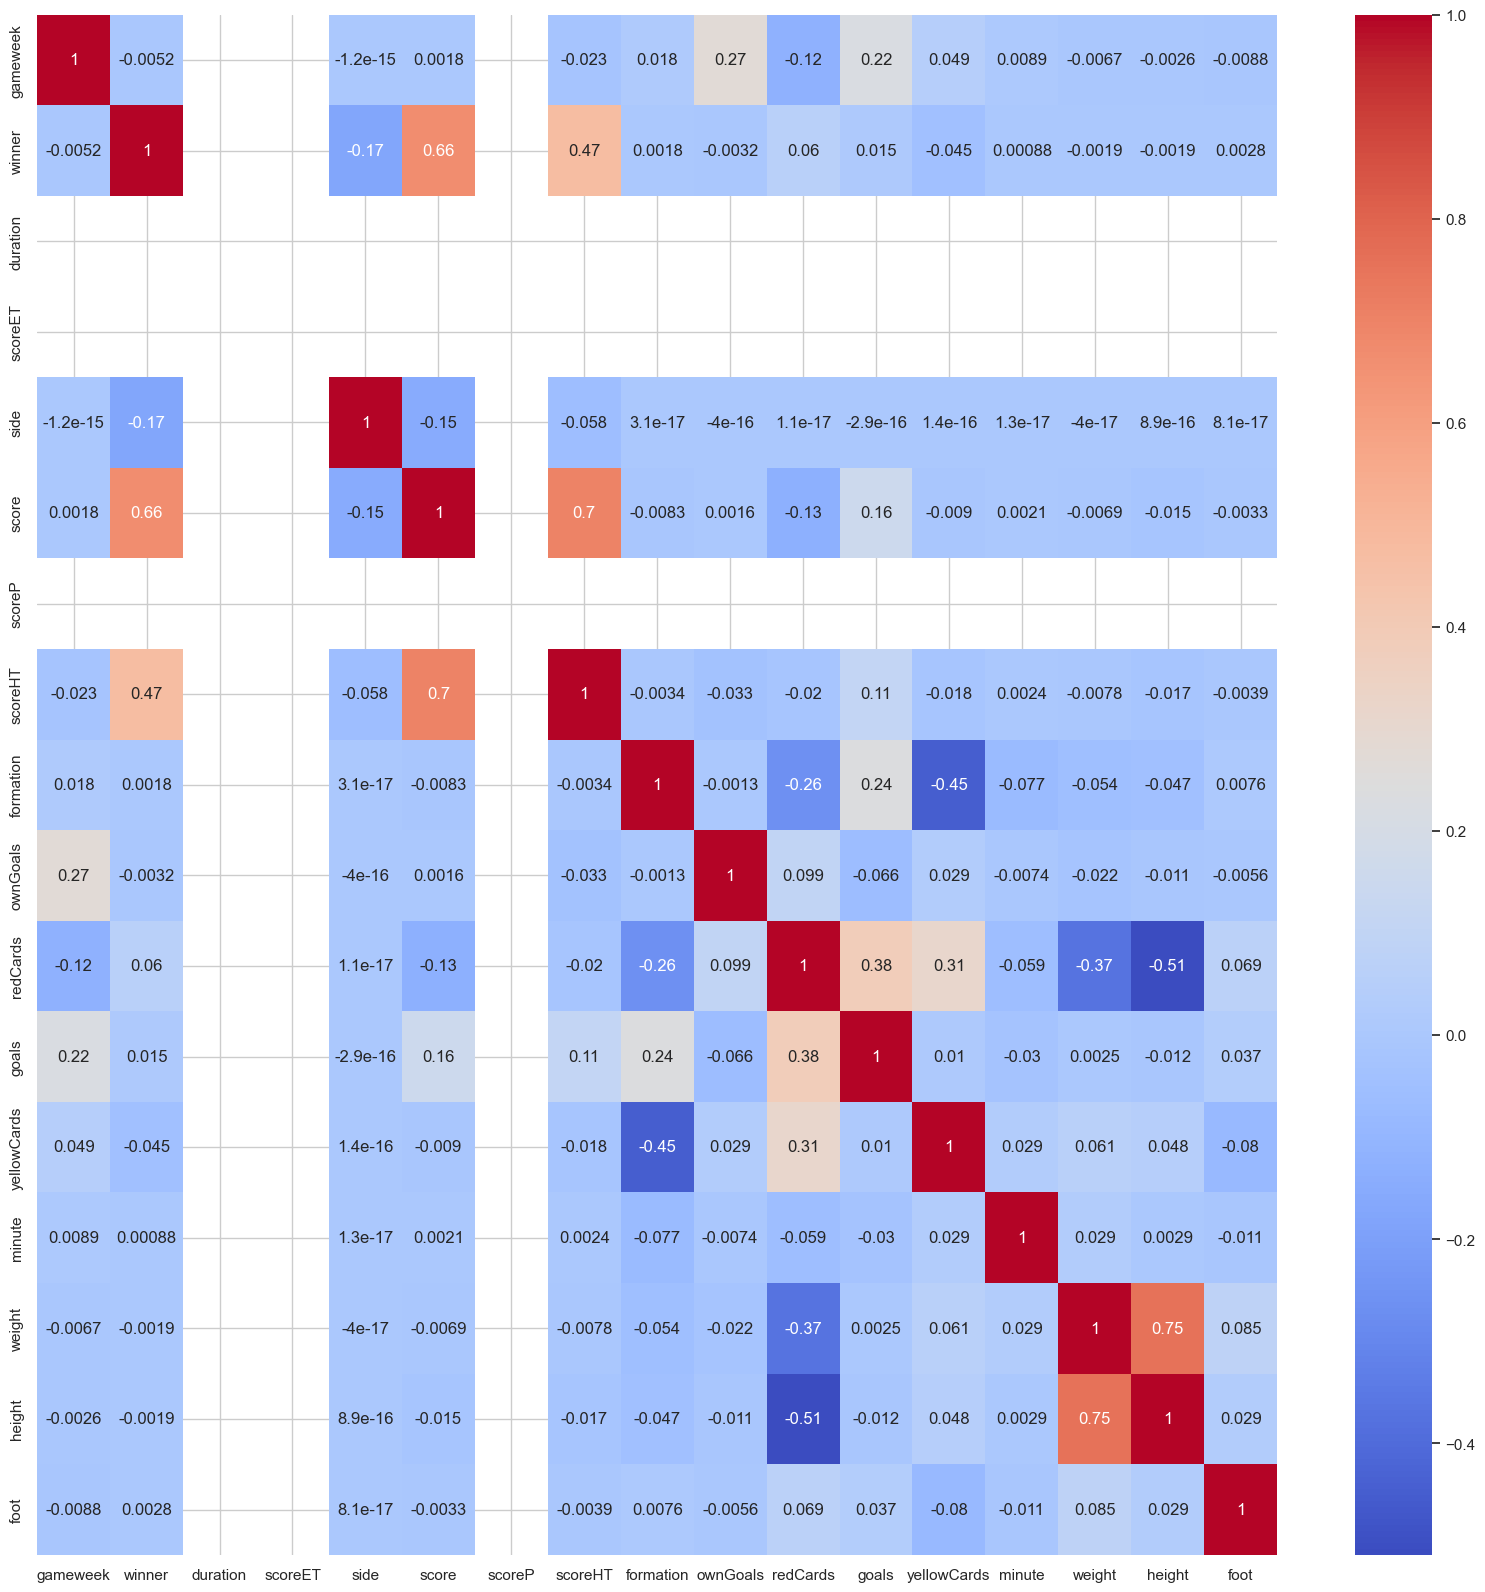

In [112]:
# show the correlation between the columns
corr = m_t_p_dp_changed.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### Left footers vs Right footers

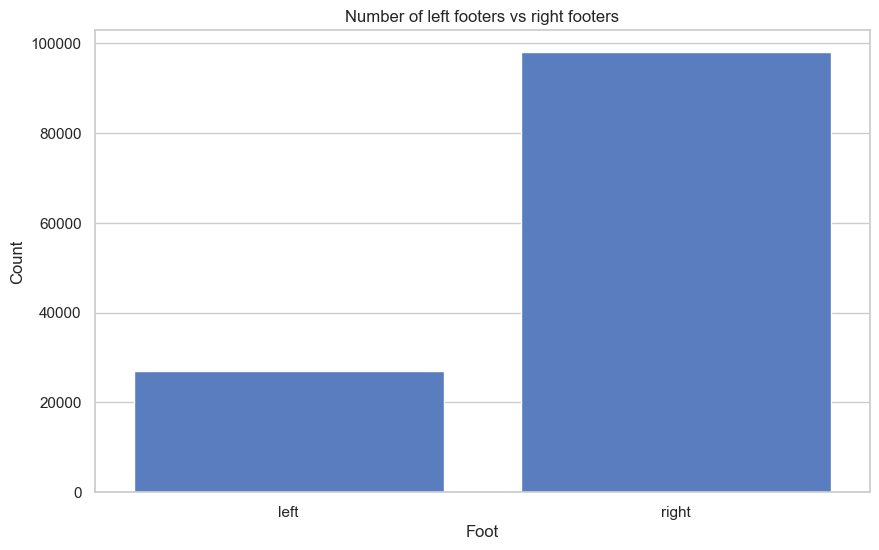

In [113]:
left_footers = len(match_team_ply_s_dply_df[match_team_ply_s_dply_df['foot'] == 'left'])
right_footers = len(match_team_ply_s_dply_df[match_team_ply_s_dply_df['foot'] == 'right'])

foot_df = pd.DataFrame({'foot': ['left', 'right'], 'count': [left_footers, right_footers]})

plt.figure(figsize=(10, 6))
sns.barplot(x='foot', y='count', data=foot_df)
plt.title('Number of left footers vs right footers')
plt.xlabel('Foot')
plt.ylabel('Count')
plt.show()

### The number of Left footers in winning team vs loosing team

         result  count
0  winning team   9851
1  lossing team  17109


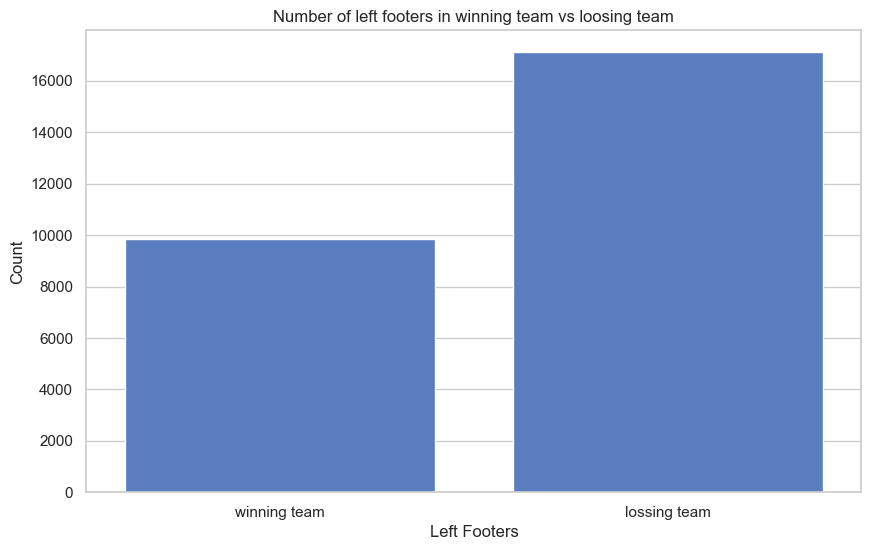

In [125]:
left_footers_win = len(match_team_ply_s_dply_df[(match_team_ply_s_dply_df['foot'] == 'left') & (match_team_ply_s_dply_df['winner'] == 1)])
left_footers_lose = len(match_team_ply_s_dply_df[(match_team_ply_s_dply_df['foot'] == 'left') & (match_team_ply_s_dply_df['winner'] == 0)])

foot_win_df = pd.DataFrame({'result': ['winning team', 'lossing team'], 'count': [left_footers_win, left_footers_lose]})
print(foot_win_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='result', y='count', data=foot_win_df)
plt.title('Number of left footers in winning team vs loosing team')
plt.xlabel('Left Footers')
plt.ylabel('Count')
plt.show()

max height

           team  max_height
0  winning team  196.942652
1  loosing team  197.174636


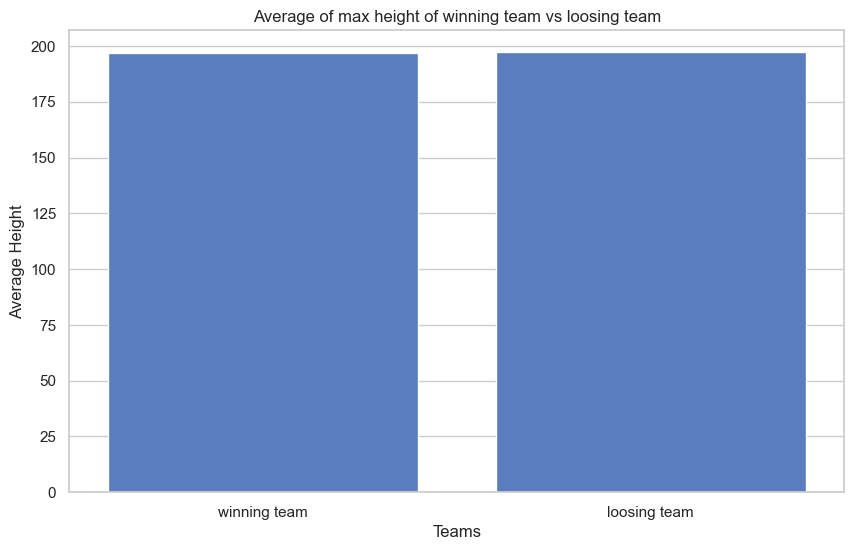

In [116]:
winning_teams = match_team_ply_s_dply_df[match_team_ply_s_dply_df['winner'] == 1]
loosing_teams = match_team_ply_s_dply_df[match_team_ply_s_dply_df['winner'] == 0]

winning_teams_max_height = winning_teams.groupby(['matchId_x', 'teamId_x'])['height'].max().reset_index()
loosing_teams_max_height = loosing_teams.groupby(['matchId_x', 'teamId_x'])['height'].max().reset_index()

height_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'max_height': [winning_teams_max_height['height'].mean(), loosing_teams_max_height['height'].mean()]})
print(height_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='team', y='max_height', data=height_df)
plt.title('Average of max height of winning team vs loosing team')
plt.xlabel('Teams')
plt.ylabel('Average Height')
plt.show()

min height

           team  min_height
0  winning team  168.698925
1  loosing team  168.596674


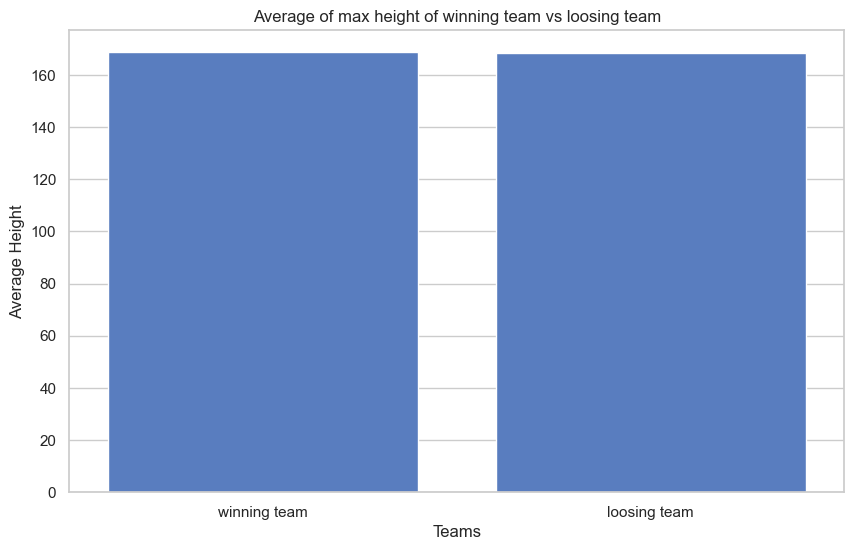

In [117]:
winning_teams = match_team_ply_s_dply_df[match_team_ply_s_dply_df['winner'] == 1]
loosing_teams = match_team_ply_s_dply_df[match_team_ply_s_dply_df['winner'] == 0]

winning_teams_max_height = winning_teams.groupby(['matchId_x', 'teamId_x'])['height'].min().reset_index()
loosing_teams_max_height = loosing_teams.groupby(['matchId_x', 'teamId_x'])['height'].min().reset_index()

height_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'min_height': [winning_teams_max_height['height'].mean(), loosing_teams_max_height['height'].mean()]})
print(height_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='team', y='min_height', data=height_df)
plt.title('Average of max height of winning team vs loosing team')
plt.xlabel('Teams')
plt.ylabel('Average Height')
plt.show()


avg height

           team  avg_height
0  winning team  181.957173
1  loosing team  181.984753


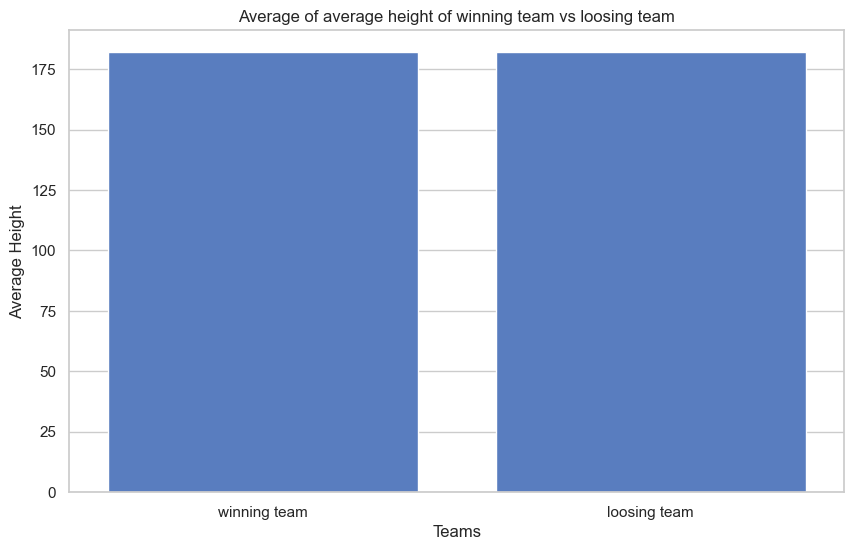

In [119]:
winning_teams_avg_height = winning_teams.groupby(['matchId_x', 'teamId_x'])['height'].mean().reset_index()
loosing_teams_avg_height = loosing_teams.groupby(['matchId_x', 'teamId_x'])['height'].mean().reset_index()

height_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'avg_height': [winning_teams_avg_height['height'].mean(), loosing_teams_avg_height['height'].mean()]})
print(height_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='team', y='avg_height', data=height_df)
plt.title('Average of average height of winning team vs loosing team')
plt.xlabel('Teams')
plt.ylabel('Average Height')
plt.show()

max wight

           team  max_weight
0  winning team   94.365591
1  loosing team   94.345114


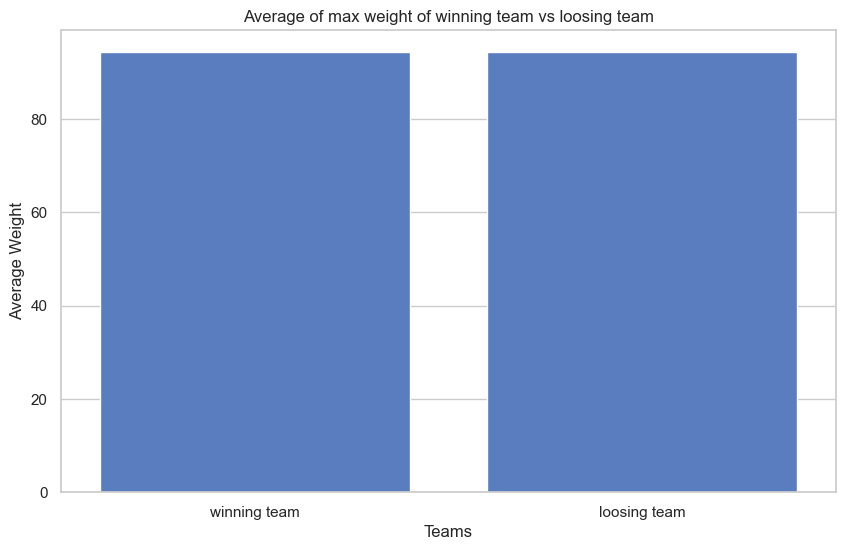

In [121]:
winning_teams_max_weight = winning_teams.groupby(['matchId_x', 'teamId_x'])['weight'].max().reset_index()
loosing_teams_max_weight = loosing_teams.groupby(['matchId_x', 'teamId_x'])['weight'].max().reset_index()

weight_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'max_weight': [winning_teams_max_weight['weight'].mean(), loosing_teams_max_weight['weight'].mean()]})
print(weight_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='team', y='max_weight', data=weight_df)
plt.title('Average of max weight of winning team vs loosing team')
plt.xlabel('Teams')
plt.ylabel('Average Weight')
plt.show()

min weight

           team  min_weight
0  winning team   62.035842
1  loosing team   62.041580


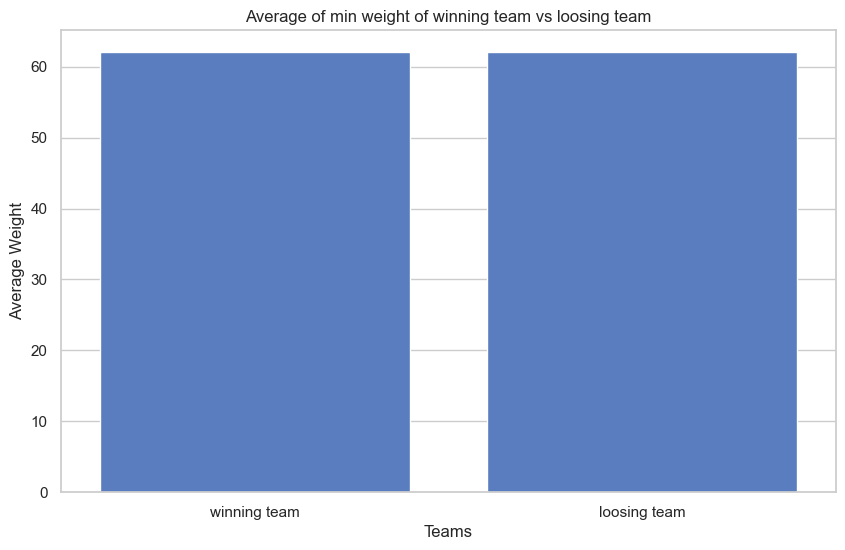

In [123]:
winning_teams_min_weight = winning_teams.groupby(['matchId_x', 'teamId_x'])['weight'].min().reset_index()
loosing_teams_min_weight = loosing_teams.groupby(['matchId_x', 'teamId_x'])['weight'].min().reset_index()

weight_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'min_weight': [winning_teams_min_weight['weight'].mean(), loosing_teams_min_weight['weight'].mean()]})
print(weight_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='team', y='min_weight', data=weight_df)
plt.title('Average of min weight of winning team vs loosing team')
plt.xlabel('Teams')
plt.ylabel('Average Weight')
plt.show()

avg weight

           team  avg_weight
0  winning team   76.643294
1  loosing team   76.678823


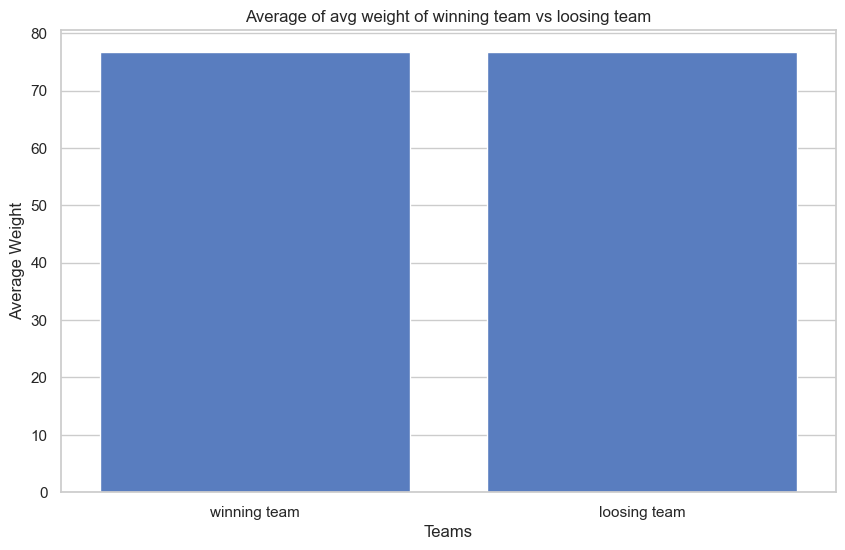

In [124]:
winning_teams_avg_weight = winning_teams.groupby(['matchId_x', 'teamId_x'])['weight'].mean().reset_index()
loosing_teams_avg_weight = loosing_teams.groupby(['matchId_x', 'teamId_x'])['weight'].mean().reset_index()

weight_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'avg_weight': [winning_teams_avg_weight['weight'].mean(), loosing_teams_avg_weight['weight'].mean()]})
print(weight_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='team', y='avg_weight', data=weight_df)
plt.title('Average of avg weight of winning team vs loosing team')
plt.xlabel('Teams')
plt.ylabel('Average Weight')
plt.show()